In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import ROOT
from ROOT import TFile, TTree, TH1F, TCanvas, TAxis, TLegend, TTreeReader, TTreeReaderValue
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


In [ ]:
# inFile = TFile("/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs/Res1ToRes2GluTo3Glu_M1-3000_R-0p5_ML_study.root")
# inTree = inFile.Get("Events")
# variable2use = [i.GetName() for i in inTree.GetListOfBranches()]
# display(variable2use)
# for branch in variable2use:
#     print(f"{branch}[0] = event.{branch}")

In [2]:
def make_df(outTree):
    data, columns = outTree.AsMatrix(return_labels=True)
    df_temp = pd.DataFrame(data=data, columns=columns)
    df = df_temp.iloc[:, :len(df_temp.columns)-1]
    label = df_temp.iloc[:, len(df_temp.columns)-1:len(df_temp.columns)]
    return df, label

In [3]:
def eval_regreesion(df, label, model):
    # Plot BDT output
    sig_index_list = np.where((label.values.ravel() == 3))[0].tolist()
    bkg_index_list = np.where((label.values.ravel() != 3))[0].tolist()
    print("Number of signals for testing: ", len(sig_index_list))
    print("Number of backgrounds for testing: ", len(bkg_index_list))
    result_sig = clf.predict(df.iloc[sig_index_list])
    result_bkg = clf.predict(df.iloc[bkg_index_list])
    max_sig_response = max(result_sig)
    max_bkg_response = max(result_bkg)
    max_response = max([max_sig_response, max_bkg_response])
    # Manually calculate classificiation efficiency
    sig_eff_list = []
    bkg_rej_list = []
    sig_purity_list = []
    sensitivity_list = []
    cut_list = []
    cut_90eff = -1
    for cut in np.linspace(0,1,101):
        N_sig = len(sig_index_list)
        N_bkg = len(bkg_index_list)
        N_sig_pass = len([x for x in result_sig if x > cut])
        N_bkg_pass = len([x for x in result_bkg if x > cut])
        if(N_bkg_pass == 0 or (N_sig_pass + N_bkg_pass) == 0):
            print("Dividing zero, end loop")
            break
        cut_list.append(cut)
        sig_eff_list.append(N_sig_pass / N_sig)
        if abs((N_sig_pass / N_sig) - 0.9) < 0.02:
            print(N_sig_pass / N_sig, cut_90eff)
            cut_90eff = cut
        bkg_rej_list.append(1 - N_bkg_pass / N_bkg)
        sig_purity_list.append(N_sig_pass / (N_sig_pass + N_bkg_pass))
        sensitivity_list.append(N_sig_pass / math.sqrt(N_bkg_pass))
    fig = plt.figure()   
    ax0 = fig.add_subplot(3,1,1)
    plt.hist(result_sig,50, color='r', alpha=0.5, label="match")
    plt.hist(result_bkg,50, color='b', alpha=0.5, label="unmatch")
    ax0.set_ylabel("Events")
    ax0.set_xlabel("BDT response")
    ax0.set_yscale('log')
    ax0.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels)
    ax1 = fig.add_subplot(3,1,2)
    ax1.plot(cut_list, sig_eff_list, label="Signal efficiency", color="red")
    ax1.plot(cut_list, bkg_rej_list, label="Background rejection", color="blue")
    ax1.plot(cut_list, sig_purity_list, label="Signal purity", color="green") 
    ax1.set_ylabel("")
    ax1.set_xlabel("Cut on BDT")
    ax1.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    ax1.grid(True)
    ax2 = fig.add_subplot(3,1,3)
    ax2.plot(cut_list, sensitivity_list, label=r"$S/\sqrt{B}$", color="black")
    ax2.set_ylabel("")
    ax2.set_xlabel("Cut on BDT")
    ax2.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels)
    ax2.grid(True)
    fig.set_figheight(20)
    fig.set_figwidth(12)
    print("90% signal efficiency cut: ", cut_90eff)
    print("Optimal cut on BDT: ", cut_list[sensitivity_list.index(max(sensitivity_list))])
    fig.show()

In [4]:
sample = "M1-3000_R-0p3"
tempFile = TFile(f"{sample}_training.root","RECREATE")
outTree = TTree()
inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/outputs/Res1ToRes2GluTo3Glu_{sample}_ML_study.root")
inTree = inFile.Get("Events")
dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
gen_dijet_matched = np.empty((1), dtype="int32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("gen_dijet_matched", gen_dijet_matched, "gen_dijet_matched/I")

for i, event in enumerate(inTree):
    if i%10000 == 0:
        print("Processing: ",i)
    gen_dijet_matched[0] = event.gen_dijet_matched
    dijet_eta[0] = event.dijet_eta
    dijet_phi[0] = event.dijet_phi
    dR_jj[0] = event.dR_jj
    dEta_jj[0] = event.dEta_jj
    dPhi_jj[0] = event.dPhi_jj
    jet_eta_0[0] = event.jet_eta_0
    jet_phi_0[0] = event.jet_phi_0
    jet_ptoverm_0[0] = event.jet_ptoverm_0
    jet_eta_1[0] = event.jet_eta_1
    jet_phi_1[0] = event.jet_phi_1
    jet_ptoverm_1[0] = event.jet_ptoverm_1
    jet_eta_2[0] = event.jet_eta_2
    jet_phi_2[0] = event.jet_phi_2
    jet_ptoverm_2[0] = event.jet_ptoverm_2
    dR_jj_j[0] = event.dR_jj_j
    dEta_jj_j[0] = event.dEta_jj_j
    dPhi_jj_j[0] = event.dPhi_jj_j
    jet_ptoverM_0[0] = event.jet_ptoverM_0
    jet_ptoverM_1[0] = event.jet_ptoverM_1
    jet_ptoverM_2[0] = event.jet_ptoverM_2
    dijet_ptoverM[0] = event.dijet_ptoverM
    outTree.Fill()
df_1 = pd.DataFrame()
label_1 = pd.DataFrame()
df_1, label_1 = make_df(outTree)

Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
Processing:  150000
Processing:  160000
Processing:  170000
Processing:  180000
Processing:  190000
Processing:  200000
Processing:  210000
Processing:  220000
Processing:  230000
Processing:  240000
Processing:  250000
Processing:  260000
Processing:  270000
Processing:  280000
Processing:  290000
Processing:  300000
Processing:  310000
Processing:  320000
Processing:  330000
Processing:  340000
Processing:  350000
Processing:  360000
Processing:  370000
Processing:  380000
Processing:  390000
Processing:  400000


In [5]:
# This cell is intended for the single traning
display(df_1.head())
display(label_1.head())
label_arr = np.array(label_1.iloc[1:,:]).ravel()
print(label_arr.shape)
sig_N = np.shape(np.where(label_arr == 3))
bkg_N = np.shape(np.where(label_arr != 3))
print(sig_N,bkg_N)

,dijet_eta,dijet_phi,dR_jj,dEta_jj,dPhi_jj,jet_eta_0,jet_phi_0,jet_ptoverm_0,jet_eta_1,jet_phi_1,...,jet_eta_2,jet_phi_2,jet_ptoverm_2,dR_jj_j,dEta_jj_j,dPhi_jj_j,jet_ptoverM_0,jet_ptoverM_1,jet_ptoverM_2,dijet_ptoverM
0,1.827711,2.912724,3.292435,1.059305,3.117371,-0.011209,2.972168,0.515176,1.048096,-0.145203,...,0.042412,0.029572,0.140163,3.391145,1.785299,2.883153,0.443919,0.315582,0.120776,0.128657
1,1.827711,2.912724,3.292435,1.059305,3.117371,-0.011209,2.972168,0.515176,1.048096,-0.145203,...,0.647705,-0.763184,0.068326,2.861871,1.180006,2.607277,0.478159,0.339923,0.063417,0.138580
2,0.000452,2.898954,2.943085,0.053621,2.942596,-0.011209,2.972168,0.950916,0.042412,0.029572,...,1.048096,-0.145203,0.676006,3.219386,1.047643,3.044157,0.443919,0.120776,0.315582,0.326401
3,0.000452,2.898954,2.943085,0.053621,2.942596,-0.011209,2.972168,0.950916,0.042412,0.029572,...,0.647705,-0.763184,0.126117,2.699782,0.647253,2.621047,0.768354,0.209044,0.101905,0.564949
4,0.090373,3.055342,2.631658,0.658915,2.547834,-0.011209,2.972168,1.322260,0.647705,-0.763184,...,1.048096,-0.145203,0.939995,3.227988,0.957723,3.082640,0.478159,0.063417,0.339923,0.427072


,gen_dijet_matched
0,1.0
1,1.0
2,2.0
3,1.0
4,3.0


(402155,)
(1, 25367) (1, 376788)


In [6]:
from joblib import dump, load
clf = load('BDT_model_1.joblib')

Number of signals for testing:  25367
Number of backgrounds for testing:  376789
0.8869397248393582 -1
0.8809871092364095 0.5
0.8809082666456419 0.51
Dividing zero, end loop
90% signal efficiency cut:  0.52
Optimal cut on BDT:  0.6900000000000001


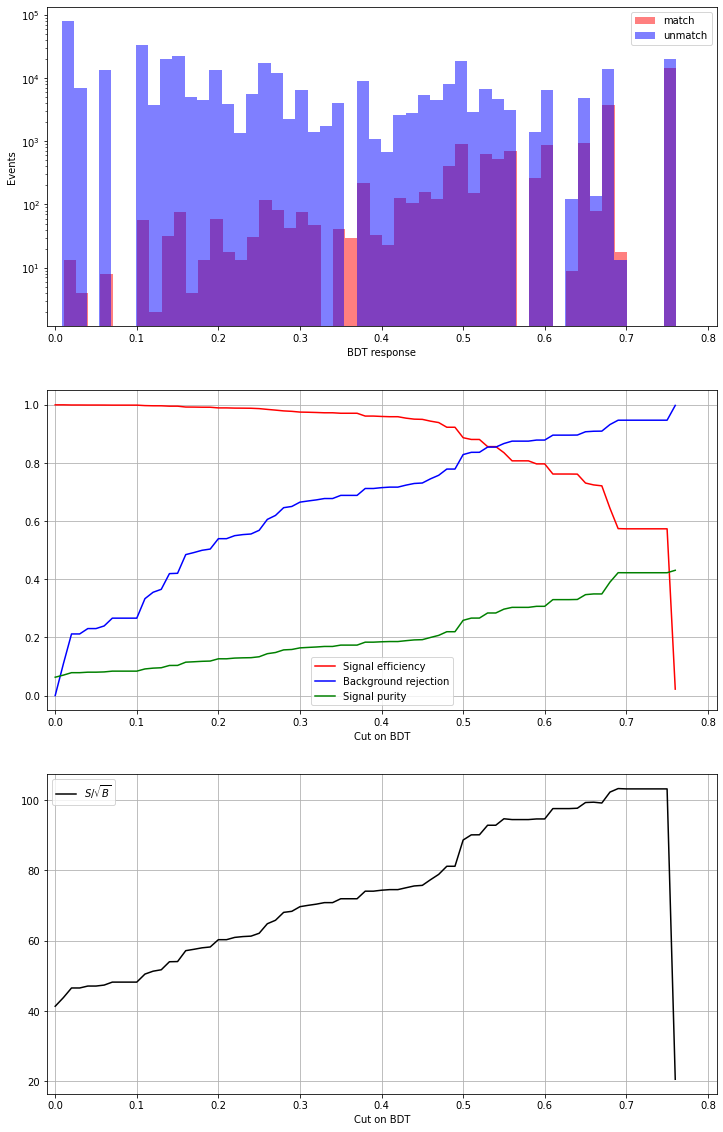

In [7]:
eval_regreesion(df_1, label_1, clf)